# Tarea 3 Curso Análisis y Limpieza de datos.


#### Profesor responsable: Jorge Alexis Castillo Sepúlveda
#### Alumno: Alejandro Méndez Miranda

El objetivo de esta tarea es evaluar el conocimiento práctico en lo que respecta a clustering y análisis de
componentes principales. Este objetivo se cumplirá desarrollando la segmentación de clientes a partir de datos aleatorios. Los métodos utilizados serán PCA para reducción de dimensionalidad y K-means para la segmentación.

##  Creando la data

In [1]:
#Se cargan las librerías necesarias

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

#Se cargan las librerías de sklearn

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [2]:
#Se crea una semilla para obtener siempre los mismos resultados
np.random.seed(342543)

### Parte 1: Generar datos aleatorios con np.random.choice()

Se simulará la compra de 500 clientes, estos clientes compran productos asociados a vegetales, leche, abarrotes, congelados, limpieza y gourmet. Además se sabe que estos clientes compran entre 1 y 10000 unidades de cada producto en el periodo de tiempo estudiado.

In [3]:
#Se genera una matriz de 500 filas y 6 columnas con valores entre 0 y 10000 (np.random.choice no toma el último valor)
datamatrix = np.random.choice(10001, 6*500).reshape(500,6)

### Parte 2: Nombres de columnas

In [4]:
#Se carga el nombre de las columnas especificados
items = ["congelados", "limpieza","vegetales","leche","abarrotes", "gourmet"]

In [5]:
#Se crea un dataframe con las filas creadas y los nombres de las columnas "items"
productos = pd.DataFrame(datamatrix, columns = items)
productos

,congelados,limpieza,vegetales,leche,abarrotes,gourmet
0,5803,7054,5883,4008,4588,146
1,7525,7366,7195,4625,3498,4951
2,7868,3223,5088,3200,7715,7666
3,8062,5820,2509,5406,2761,2527
4,6137,1212,9244,9329,2017,5902
...,...,...,...,...,...,...
495,1091,683,2603,8922,2111,2840
496,3262,4706,6902,6715,1425,9755
497,1538,2512,3204,190,5623,2755
498,2685,7626,2343,4762,3939,1749


In [6]:
productos.describe()

,congelados,limpieza,vegetales,leche,abarrotes,gourmet
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000
mean,5089.758000,5167.752000,5056.242000,4975.152000,5096.662000,4885.42200
std,2920.261123,2726.252415,2865.725338,2879.832822,2785.846805,2977.10284
min,43.000000,11.000000,18.000000,15.000000,4.000000,9.00000
25%,2490.000000,2868.500000,2609.750000,2558.750000,2819.000000,2388.50000
50%,5000.000000,5236.000000,5158.500000,4966.000000,5094.000000,4745.00000
75%,7599.250000,7505.500000,7545.500000,7362.750000,7520.000000,7480.75000
max,9999.000000,9996.000000,9985.000000,9955.000000,9972.000000,9995.00000


Se puede apreciar que cada producto sigue aproximadamente una distribución uniforme ya que cada cuartil tiene valores muy cercanos entre los distintos productos. Además para se pueden apreciar valores para cada cuartil del tipo:

- Primer cuartil  Q(0.25) ~ 2500
- Segundo cuartil Q(0.50) ~ 5000
- Tercer cuartil  Q(0.75) ~ 7500

## Preparando los datos

### Parte 3: Normalizar los datos

Para normalizar los datos se utilizara StandardScaler() de la librería sklearn que estandariza removiendo la media y dividiendo por la desviación estandar de la muestra para cada artículo.

$$ Z = \frac{x-\bar{X}}{S} $$

In [7]:
#Se estandariza restando la media y dividiendo por la desviación estandar
x2 = StandardScaler()
x = x2.fit_transform(productos)

In [8]:
#Se visualiza como dataframe utilizando los datos escalados y reutilizando la variable items
productos_estand = pd.DataFrame(x, columns = items)
productos_estand


,congelados,limpieza,vegetales,leche,abarrotes,gourmet
0,0.244484,0.692576,0.288788,-0.336173,-0.182771,-1.593552
1,0.834748,0.807133,0.747071,-0.121709,-0.574426,0.022050
2,0.952320,-0.714057,0.011093,-0.617025,0.940813,0.934923
3,1.018819,0.239487,-0.889755,0.149759,-0.839243,-0.792980
4,0.358972,-1.452438,1.462789,1.513355,-1.106574,0.341808
...,...,...,...,...,...,...
495,-1.370687,-1.646672,-0.856921,1.371885,-1.072798,-0.687739
496,-0.626515,-0.169542,0.644726,0.604754,-1.319290,1.637315
497,-1.217465,-0.975116,-0.646990,-1.663272,0.189122,-0.716319
498,-0.824298,0.902598,-0.947739,-0.074090,-0.415967,-1.054570


Los objetos fueron escalados y centrados en 0. Para analizar los valores se realiza un .describe() de la data

In [9]:
productos_estand.describe()

,congelados,limpieza,vegetales,leche,abarrotes,gourmet
count,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02
mean,4.307665e-17,-1.567635e-16,-7.371881e-17,-4.440892e-19,-8.348877e-17,1.338374e-16
std,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00
min,-1.729918e+00,-1.893411e+00,-1.759864e+00,-1.724100e+00,-1.829879e+00,-1.639616e+00
25%,-8.911401e-01,-8.442192e-01,-8.545628e-01,-8.399175e-01,-8.184022e-01,-8.395487e-01
50%,-3.076707e-02,2.505870e-02,3.571885e-02,-3.181145e-03,-9.565013e-04,-4.721457e-02
75%,8.601989e-01,8.583539e-01,8.695010e-01,8.299055e-01,8.707460e-01,8.726360e-01
max,1.682781e+00,1.772794e+00,1.721621e+00,1.730946e+00,1.751791e+00,1.718011e+00


Se observa que tienen media cercana a 0 y desviación estandar cercana a 1

### Parte  4: Remover outliers

Para eliminar los outliers se calcularán los cuartiles 1,3 y el rango interquartilico , donde se eliminarán los datos fuera del rango:

$$[Q_1\ -\ 1.5\times IQR\ ,\ Q3\ +\ 1.5\times IQR]$$

In [10]:
#Se eliminan los datos outliers
data_outliers = productos_estand

Q1 = data_outliers.quantile(0.25)
Q3 = data_outliers.quantile(0.75)
IQR = Q3 - Q1

#Se realiza el filtro de los datos
productos_nout = productos_estand[~((data_outliers < (Q1 - 1.5 * IQR))| (data_outliers > (Q3 + 1.5 * IQR))).any(axis = 1)]

In [11]:
#Se visualiza como queda el dataframe sin outliers
productos_nout

,congelados,limpieza,vegetales,leche,abarrotes,gourmet
0,0.244484,0.692576,0.288788,-0.336173,-0.182771,-1.593552
1,0.834748,0.807133,0.747071,-0.121709,-0.574426,0.022050
2,0.952320,-0.714057,0.011093,-0.617025,0.940813,0.934923
3,1.018819,0.239487,-0.889755,0.149759,-0.839243,-0.792980
4,0.358972,-1.452438,1.462789,1.513355,-1.106574,0.341808
...,...,...,...,...,...,...
495,-1.370687,-1.646672,-0.856921,1.371885,-1.072798,-0.687739
496,-0.626515,-0.169542,0.644726,0.604754,-1.319290,1.637315
497,-1.217465,-0.975116,-0.646990,-1.663272,0.189122,-0.716319
498,-0.824298,0.902598,-0.947739,-0.074090,-0.415967,-1.054570


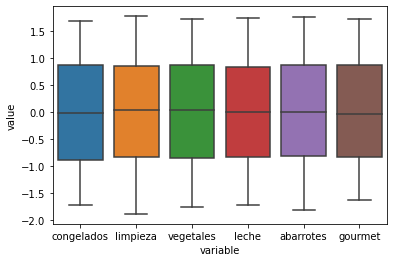

In [12]:
#Se realiza un boxplot para visualizar si existen outliers, debido a que el número de filas no se redujo
sns.boxplot(x="variable", y="value", data=pd.melt(productos_nout))
plt.show()

Con el seed seleccionado no se generaron outliers, puede que al cambiar de aleatorización puedan aparecer, pero el código se encargaría de eliminarlos. Aun así, se eliminarán los outliers tomando otro enfoque, viendo los datos de manera correlacionada, debido a que se debe analizar las compras de los clientes considerando todos los items en conjunto y no individualmente, para esto se utilizará el método DBSCAN de clusterización que nos ayudará con la detección de los outliers.

### Eliminando datos outliers con DBSCAN model

Para la implementación de lo que se realizó a continuación se utilizaron los siguientes enlaces como referencia:

* [Explicación de la distancia de Mahalanobis](https://www.statisticshowto.com/mahalanobis-distance/#:~:text=The%20Mahalanobis%20distance%20(MD)%20is,be%20measured%20with%20a%20ruler)
* [Implementación de DBSCAN y estimación de parámetro min_samples para DBSCAN](https://towardsdatascience.com/explaining-dbscan-clustering-18eaf5c83b31)
* [Estimación parámetro esp para DBSCAN](https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc)

In [13]:
#Para los siguientes pasos se crea una variable nueva que contenga los datos, se transformará en array y
#se obtendrá la matriz de covarianzas, parámetro solicitado al utilizar la métrica mahalanobis.

dbscan_data = productos_nout
dbscan_data = dbscan_data.values.astype("float32", copy = False)
covariance = np.cov(dbscan_data, rowvar=False)

#### Obtener el valor de eps


In [14]:
#Se usa el algoritmo de knn para obtener las distancias entre los puntos, 
#Según recomiendan se puede utilizar el gráfico de los valores de distancias obtenidos en el método knn
#donde el valor óptimo de eps es en el codo (o rodilla) del plot de distancias acumuladas.
#Se calculan las distancias con la distancia de mahalanobis.

neighm = NearestNeighbors(n_neighbors=5, metric = "mahalanobis", metric_params={"V": covariance})
nbrsm = neighm.fit(dbscan_data)
distancesm, indicesm = nbrsm.kneighbors(dbscan_data)
distancesm = np.sort(distancesm, axis=0)
distancesm = distancesm[:,1]

In [15]:
#Se calculan las distancias con la distancia minkowski que es la que viene por defecto.
neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(dbscan_data)
distances, indices = nbrs.kneighbors(dbscan_data)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

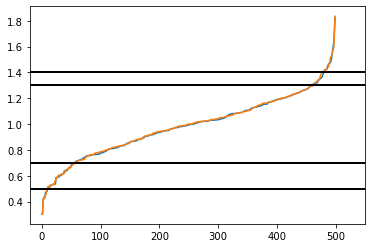

In [16]:
#Se realiza el plot de las dos curvas.
plt.plot(distances)
plt.plot(distancesm)
#Se seleccionan los posibles valores de eps realizando una linea con valor de Y fijo.
plt.plot([-200, 600], [1.3,1.3], color='k', linestyle='-', linewidth=2)
plt.plot([-200, 600], [1.4,1.4], color='k', linestyle='-', linewidth=2)
plt.plot([-200, 600], [0.5,0.5], color='k', linestyle='-', linewidth=2)
plt.plot([-200, 600], [0.7,0.7], color='k', linestyle='-', linewidth=2)
plt.xlim([-20,550])
plt.show()

No existen diferencias visibles entre las distancias calculadas por las distintas métricas (ante la duda de que distancia sería más representativa), se observa que los valores de eps óptimos estarían entre 1.3 y 1.4 (codo superior) o entre 0.5 y 0.7 (codo inferior). 

#### Obtener min_samples para DBSCAN

In [17]:
#Por lo que pude encontrar, la manera de encontrar el mejor valor para min_samples es casi prueba y error.
#Uno de los valores que nos puede señalar que tan bien clusterizado están los datos es el coeficiente de silueta.

#Se seleccionan los valores entre los que se calculará el coeficiente de silueta.
pca_eps_values = np.arange(0.5,1.5,0.1)
pca_min_samples = np.arange(3,16)
#Se crea el array para comenzar el bucle que contiene el valor de eps y min_samples.
mesh = np.array(np.meshgrid(pca_eps_values, pca_min_samples))
combinations = mesh.T.reshape(-1, 2)
pca_dbscan_params = combinations
#Se generan listas vacías para luego crear el dataframe con la información de n°clusters, coeficiente de silueta,
#valor de eps, valor de min_samples y n°outliers.
pca_no_of_clusters = []
pca_sil_score = []
pca_epsvalues = []
pca_min_samp = []
n_outliers = []
#Se recorre la lista que contiene las combinaciones entre valores de esp y min_samples.
for p in pca_dbscan_params:
    eps = p[0]
    minnum = int(p[1])
    #En cada bucle se calculan los clusters utilizando DBSCAN.
    pca_dbscan_cluster = DBSCAN(eps =eps, min_samples = minnum, metric="mahalanobis", metric_params={"V": covariance}).fit(dbscan_data)
    #El coeficiente de silueta no funciona si solo existe un único cluster. Esto se genera cuando todos los datos
    #clusterizados son outliers y suman (-500) o todos pertenecen a un solo cluster (y suman 0).
    if (sum(pca_dbscan_cluster.labels_) != -500) & (sum(pca_dbscan_cluster.labels_) != 0):
        #Se agrega el número de outliers a la lista.
        n_outliers.append(pca_dbscan_cluster.labels_[pca_dbscan_cluster.labels_ == -1].sum()*-1)
        #Se agregan los valores de esp a la lista.
        pca_epsvalues.append(p[0])
        #Se agregan los valores de min_samp a la lista.
        pca_min_samp.append(p[1])
        #Se agregan los números de clusters a la lista.
        pca_no_of_clusters.append(len(np.unique(pca_dbscan_cluster.labels_)))
        #Se calcula el coeficiente de silueta y se agrega a la lista.
        pca_sil_score.append(silhouette_score(X =dbscan_data, labels = pca_dbscan_cluster.labels_, metric = "mahalanobis"))

#Se crea el dataframe los datos de las listas formadas.
pca_eps_min = list(zip(pca_no_of_clusters, pca_sil_score, pca_epsvalues, pca_min_samp,n_outliers))
pca_eps_min_df = pd.DataFrame(pca_eps_min, columns=['no_of_clusters', 'silhouette_score', 'epsilon_values', 'minimum_points', "n_outliers"])
pca_eps_min_df.sort_values("silhouette_score")

,no_of_clusters,silhouette_score,epsilon_values,minimum_points,n_outliers
1,10,-0.318191,0.8,3.0,472
2,24,-0.307157,0.9,3.0,413
6,7,-0.290419,1.0,5.0,467
5,17,-0.286638,1.0,4.0,413
3,8,-0.279880,0.9,4.0,467
9,15,-0.249490,1.1,5.0,390
10,7,-0.240794,1.1,6.0,446
13,12,-0.236393,1.2,4.0,173
17,8,-0.230928,1.2,8.0,434
16,11,-0.217414,1.2,7.0,396


Se calcularán los cluster con DBSCAN utilizando los parámetros con los que se obtuvo el mayor coeficiente de silueta e intentando eliminar valores cercanos al 10% de los datos y no mucho más. Estos valores corresponden al penúltimo valor de la lista mostrada, del cual sus valores son:

- eps = 1.4
- min_samples = 5

Con los que se obtuvo:

- silhouette_score = 0.030998
- n_outliers = 63
- % datos eliminados = 12.6%

In [18]:
#Se crea el objeto DBSCAN.
clusterer = DBSCAN(eps = 1.4, min_samples = 5, metric="mahalanobis", metric_params={"V": covariance})
#Se ajustan los datos.
clusterer.fit(dbscan_data)

DBSCAN(eps=1.4, metric='mahalanobis',
       metric_params={'V': array([[ 1.00200401, -0.04514143,  0.03204664, -0.04006369, -0.01736791,
         0.09265008],
       [-0.04514143,  1.002004  ,  0.04089019,  0.03898994,  0.02668463,
         0.01531594],
       [ 0.03204664,  0.04089019,  1.00200401,  0.01753036,  0.03929649,
         0.00398596],
       [-0.04006369,  0.03898994,  0.01753036,  1.00200401,  0.02190674,
        -0.05971683],
       [-0.01736791,  0.02668463,  0.03929649,  0.02190674,  1.00200401,
        -0.0525109 ],
       [ 0.09265008,  0.01531594,  0.00398596, -0.05971683, -0.0525109 ,
         1.00200401]])})

In [19]:
#Se imprimen los labels de los clusters.
clusterer.labels_

array([ 0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,
        0, -1, -1,  1,  0, -1,  0,  0,  0, -1, -1,  0, -1,  0,  0,  0,  0,
        0, -1,  0, -1,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,
        0,  0,  0, -1,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0, -1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,
        0,  0,  0,  0,  0, -1,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,
        0,  0,  0, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0, -1,
        0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1,  0,  0,
        0,  0,  0, -1,  0

In [20]:
#Finalmente se filtran los datos.
productos_nout = productos_nout[clusterer.labels_ != -1]
productos_nout.reset_index(inplace = True, drop =True )

In [21]:
productos_nout

,congelados,limpieza,vegetales,leche,abarrotes,gourmet
0,0.244484,0.692576,0.288788,-0.336173,-0.182771,-1.593552
1,0.834748,0.807133,0.747071,-0.121709,-0.574426,0.022050
2,0.952320,-0.714057,0.011093,-0.617025,0.940813,0.934923
3,1.018819,0.239487,-0.889755,0.149759,-0.839243,-0.792980
4,-0.130858,-1.763065,-1.625383,0.403499,1.419063,-0.520967
...,...,...,...,...,...,...
432,-0.152111,-0.882956,-0.809066,0.741705,-1.016386,1.398589
433,-1.370687,-1.646672,-0.856921,1.371885,-1.072798,-0.687739
434,-0.626515,-0.169542,0.644726,0.604754,-1.319290,1.637315
435,-1.217465,-0.975116,-0.646990,-1.663272,0.189122,-0.716319


Utilizando los pasos mostrados, con el método DBSCAN para detectar los outliers se logró eliminar el 12.6% de los datos considerados como outliers.

## Componentes principales

### Parte 5: Aplicar componentes principales

In [22]:
#Se crea el elemento PCA sin argumentos y se ajustan los datos.
descdata = PCA(n_components = 6)
ftr =descdata.fit_transform(productos_nout)

### Parte 6: Interpretar las dimensiones y varianza explicada

In [23]:
#El ratio de la varianza explicada.
descdata.explained_variance_ratio_

array([0.21269727, 0.18693261, 0.16424147, 0.15119014, 0.1472971 ,
       0.13764141])

Se observa que las componentes explican:

| Componentes  | % individual| % acumulado|
|--------------|-------------|------------|
|1ra Componente| 21.21 | 21.21| 
|2da Componente| 18.69 | 39.90|
|3ra Componente| 16.42 | 56.32|
|4ta Componente| 15.11 | 71.43|
|5ta Componente| 14.72 | 86.15|
|6ta Componente| 13.76 | 100|
    

In [24]:
#Los componentes (vectores propios ordenados según la varianza explicada).
descdata.components_

array([[ 0.56925266, -0.12866745, -0.04540004, -0.46550229, -0.12935646,
         0.65108329],
       [-0.07030508,  0.61892819,  0.59057402,  0.28305065,  0.00275293,
         0.42788103],
       [-0.22803604,  0.07040838, -0.23312712,  0.12772352, -0.92821229,
         0.10393561],
       [-0.66045474,  0.22382486, -0.39421155, -0.39004216,  0.26579306,
         0.36813093],
       [ 0.1852785 , -0.02050982, -0.54559485,  0.7053923 ,  0.2256591 ,
         0.34507558],
       [-0.38533049, -0.73817141,  0.37647898,  0.19278344,  0.01064357,
         0.35722294]])

In [25]:
componentes = pd.DataFrame(abs(descdata.components_.T), index = items, columns = ["componente %s"%str(i+1) for i in range(len(descdata.components_))] )
componentes

,componente 1,componente 2,componente 3,componente 4,componente 5,componente 6
congelados,0.569253,0.070305,0.228036,0.660455,0.185278,0.385330
limpieza,0.128667,0.618928,0.070408,0.223825,0.020510,0.738171
vegetales,0.045400,0.590574,0.233127,0.394212,0.545595,0.376479
leche,0.465502,0.283051,0.127724,0.390042,0.705392,0.192783
abarrotes,0.129356,0.002753,0.928212,0.265793,0.225659,0.010644
gourmet,0.651083,0.427881,0.103936,0.368131,0.345076,0.357223


Ahora hay que señalar cuales son las variables más importantes para cada componente. Es un poco complicado de ver al observar los valores, por lo cual se realizará un ranking de estos.

In [26]:
listlist = []
for i in range(len(descdata.components_)):
    array = abs(descdata.components_[i])
    temp = array.argsort()
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(len(array))
    listlist.append(ranks)

componentes_rank = pd.DataFrame(np.array(listlist).T, index = items, columns = ["componente %s"%str(i+1) for i in range(len(descdata.components_))] )
componentes_rank

,componente 1,componente 2,componente 3,componente 4,componente 5,componente 6
congelados,4,1,3,5,1,4
limpieza,1,5,0,0,0,5
vegetales,0,4,4,4,4,3
leche,3,2,2,3,5,1
abarrotes,2,0,5,1,2,0
gourmet,5,3,1,2,3,2


Mientras mayor sea el valor, mayor es la importancia para cada componente por lo cual (analizando los valores absolutos):

|Importancia | ++         |   +        |   -        |    --    |
|------------|------------|------------|------------|----------|
|Componente 1| gourmet    | congelados | limpieza   | vegetales|
|Componente 2| limpieza   | vegetales  | congelados | abarrotes|
|Componente 3| abarrotes  | vegetales  | gourmet    | limpieza |
|Componente 4| congelados | vegetales  | abarrotes  | limpieza |
|Componente 5| leche      | vegetales  | congelados | limpieza |
|Componente 6| limpieza   | congelados | leche      | abarrotes|

Como se puede observar, si se toma la componente 1 y 2 se explica en gran parte todas las variables excepto abarrotes que no tiene mucho valor en las componentes. Hay que señalar que al excluir las demás componentes se pierde una gran cantidad de información, pero se gana en la generación de un método más sencillo de entender.

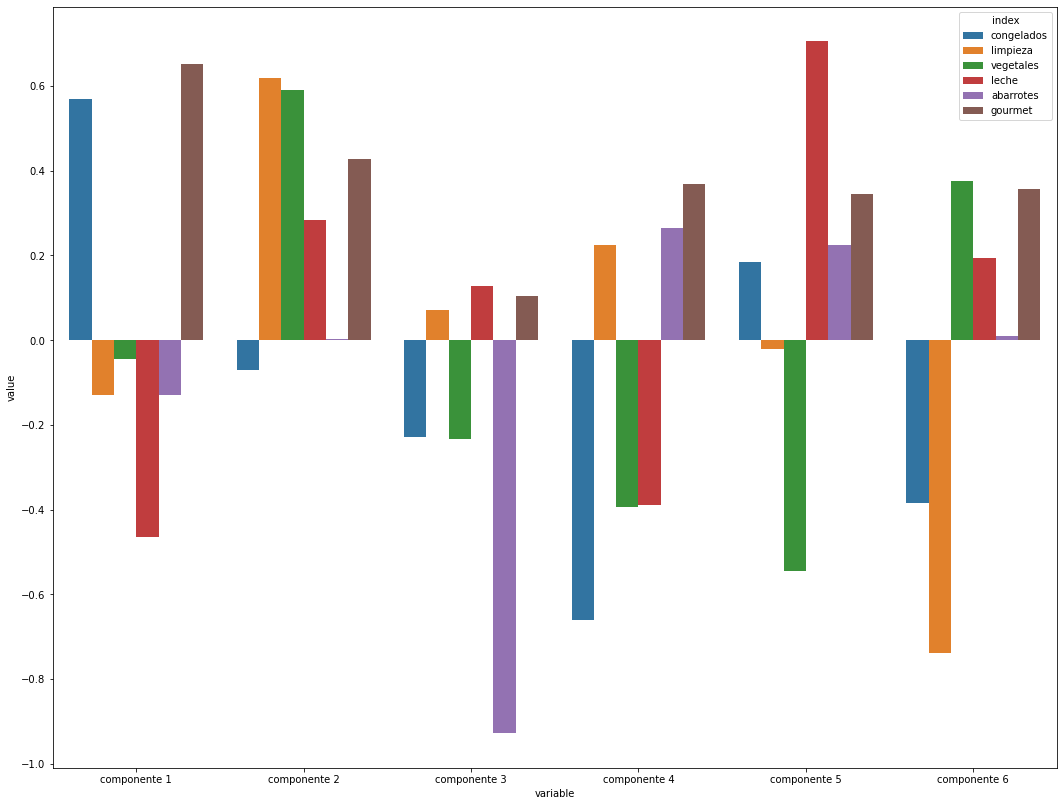

In [27]:
foplot = pd.DataFrame(descdata.components_.T, columns =["componente {}".format(i) for i in  range(1,7)], index = items)
foplot=pd.melt(foplot)
indexs = items*6
foplot["index"] = indexs
foplot = foplot.set_index("index")
plt.figure(figsize=(18,14))
sns.barplot(x="variable", y = "value", data =foplot, hue = foplot.index)
plt.show()

Aunque en la tabla se vio como afectaba cada variable a la componente en valor absoluto, este efecto puede ser negativo o positivo en la componente. Al analizar el gráfico se puede visualizar que:

* **Componente 1**: Mientras más por sobre la media de congelados y gourmet compran el valor es más positivo. Mientras más bajo de la media (o negativos al estandarizar) compren los demás productos el valor es más positivo de la componente. Podría indicarnos negocios de congelados o restaurantes de lujo que necesitan estos productos.

* **Componente 2**: En general se vuelve positivo con la compra de cualquier producto. Congelados tiene un efecto negativo pequeño, mientras que abarrotes no presenta información en esta componente. Podría indicarnos la presencia de un supermercado si es que la componente es alta o negocios más pequeños si la componente es baja, pero es complicado decidir solo mirando esta componente, debido a que abarrotes puede que sea importante para este tipo de selección
.

* **Componente 3**: Contiene principalmente la información de los abarrotes, mientras mayor por sobre la media sea la compra de abarrotes, más negativo se ve esta variable. Las otras variables no afectan en gran cantidad esta componente.

* **Componente 5**: Cuando se vuelve positiva esta componente se debe a que se compra más productos lacteos, que podría ser una lechería o quesería.

Las otras componentes es más complicado de interpretar al ser una combinación de importancia para cada variable.

### Parte 7: Reducción a dos dimensiones

In [28]:
#Ahora se realiza el análisis seleccionando 2 componentes
descdata2 = PCA(n_components = 2)
#Los valores transformados se guardan en la variable Y
Y = descdata2.fit_transform(productos_nout)

Si se consideran las dos componentes que tienen una mayor varianza eplicada, la suma total daría:

$$var\_coef1 + var\_coef2 = 21.2\% + 18.6\% = 39.9\%$$

Es poca varianza explicada, pero para la generación de un modelo sencillo es un buen punto de partida.

In [29]:
#Se crea un dataframe con los datos y se visualiza
transform_data = pd.DataFrame(Y,  columns = ["Transformada 1", "Transformada 2"] )
transform_data

,Transformada 1,Transformada 2
0,-0.817048,-0.218031
1,0.486136,0.832935
2,1.411128,-0.296915
3,0.115504,-0.770632
4,-0.481033,-2.169255
...,...,...
432,0.763964,-0.230574
433,-1.473703,-1.360331
434,0.594476,1.165451
435,-0.251392,-1.699337


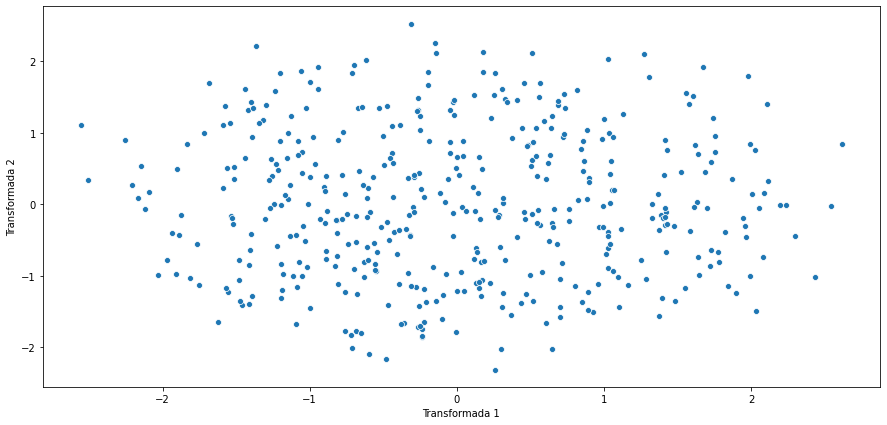

In [30]:
#Se realiza un scatterplot para realizar un primer vistazo de la nueva distribución 
plt.figure(figsize=(15,7))
g = sns.scatterplot(x = "Transformada 1", y = "Transformada 2", data = transform_data)

Las dos componentes graficadas en un scatterplot nos muestran datos un poco complicado de segmentar en grupos claros al repartirse uniformemente como una nube de puntos, aun así es posible que se puedan dividir por zonas, por ejemplo, los de la izquierda contra los de la derecha, los de arriba contra los de abajo y así.

Una forma de representar las componentes es mediante un biplot. El código que se utilizó se obtuvo de [Link biplot](https://towardsdatascience.com/pca-clearly-explained-how-when-why-to-use-it-and-feature-importance-a-guide-in-python-7c274582c37e) con pequeñas modificaciones.

In [31]:
def biplot(score, coeff , y):
    '''
    Author: Serafeim Loukas, serafeim.loukas@epfl.ch
    Inputs:
       score: the projected data
       coeff: the eigenvectors (PCs)
       y: the class labels
   '''
    xs = score[:,0] # projection on PC1
    ys = score[:,1] # projection on PC2
    n = coeff.shape[0] # number of variables
    plt.figure(figsize=(10,8), dpi=100)
    classes = np.unique(y)
    colors = ['g','r','y']
    markers=['o','^','x']
    for s,l in enumerate(classes):
        plt.scatter(xs[y==l],ys[y==l], c = "orange", marker=markers[s]) # color based on group
    for i in range(n):
        #plot as arrows the variable scores (each variable has a score for PC1 and one for PC2)
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], color = 'k', alpha = 0.9,linestyle = '-',linewidth = 1.5, overhang=0.2)
        plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, ""+str(items[i]), color = 'k', ha = 'center', va = 'center',fontsize=10)

    plt.xlabel("PC{}".format(1), size=14)
    plt.ylabel("PC{}".format(2), size=14)
    limx= int(xs.max()) + 1
    limy= int(ys.max()) + 1
    plt.xlim([-limx,limx])
    plt.ylim([-limy,limy])
    plt.grid()
    plt.tick_params(axis='both', which='both', labelsize=14)

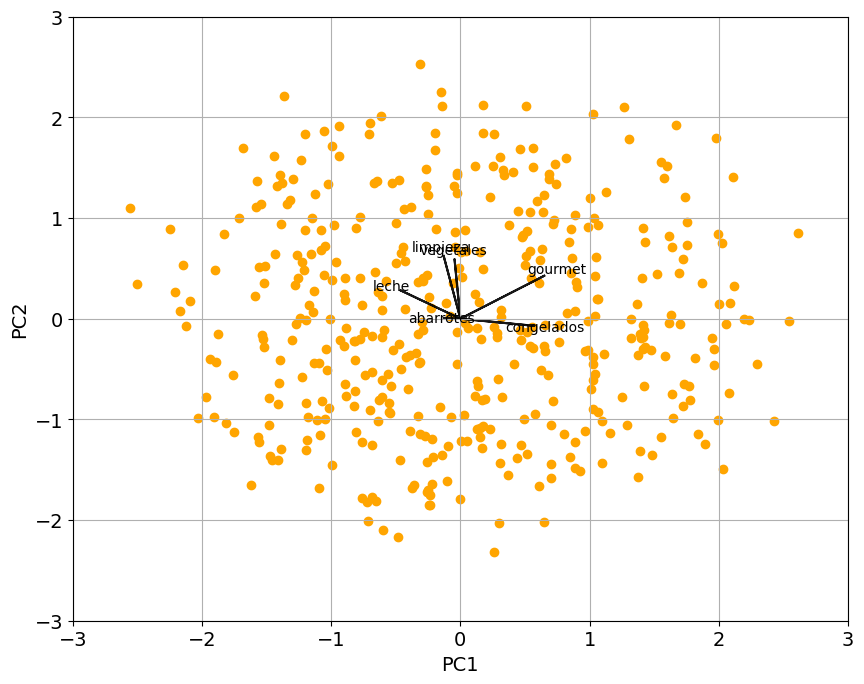

In [32]:
# Se ejecuta la función con los parámetros propios.
biplot(Y[:,0:2], np.transpose(descdata2.components_[0:2, :]), np.ones(437))
plt.show()

Se pueden observar varias cosas del gráfico:

1. Las variables congelados, gourmet y leche son las más importantes para PC1.
2. Las variables limpieza, vegetales y gourmet son las más importantes para PC2.
3. La variable abarrotes es explicada  pobremente por estas dos componentes.


## Segmentación de clientes

### Parte 8 y 9: Aplicar clusterización y obtener métricas

In [33]:
#Se guarda la información como array.
X = transform_data.to_numpy()
#Se crea una variable con el número máximo de clusters a calcular.
max_k = 8
#Con este número máximo se crea una lista para iterar más tarde.
K = range(1,max_k)
#Suma de los cuadrados internos para luego utilizar el método del codo.
ssw = [] 
#Como los clusters van a variar se crea una paleta de colores dependiendo del número de clusters.
color_palette = [plt.cm.Dark2(float(i)/max_k) for i in K]
labels_array = []

Cluster 0 con 205 objetos
Cluster 1 con 232 objetos
Para k =  2  el promedio de la silueta es: 0.3477984970975834
   - Para i =  0 la silueta del cluster vale:  0.3405608092071476
   - Para i =  1 la silueta del cluster vale:  0.3541938678628392


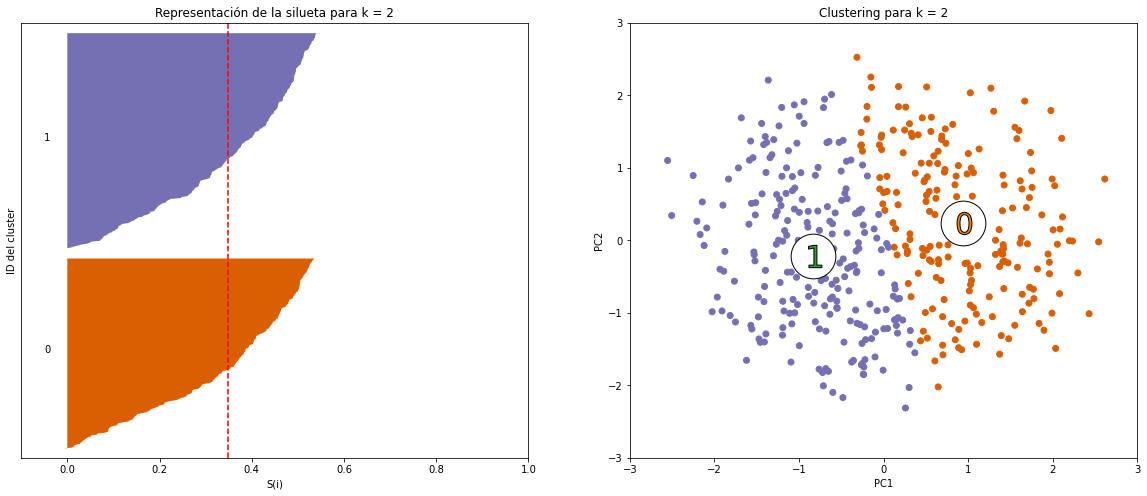

Cluster 0 con 139 objetos
Cluster 1 con 155 objetos
Cluster 2 con 143 objetos
Para k =  3  el promedio de la silueta es: 0.3729145520961049
   - Para i =  0 la silueta del cluster vale:  0.3837079071633473
   - Para i =  1 la silueta del cluster vale:  0.39904308305671204
   - Para i =  2 la silueta del cluster vale:  0.33410197410141396


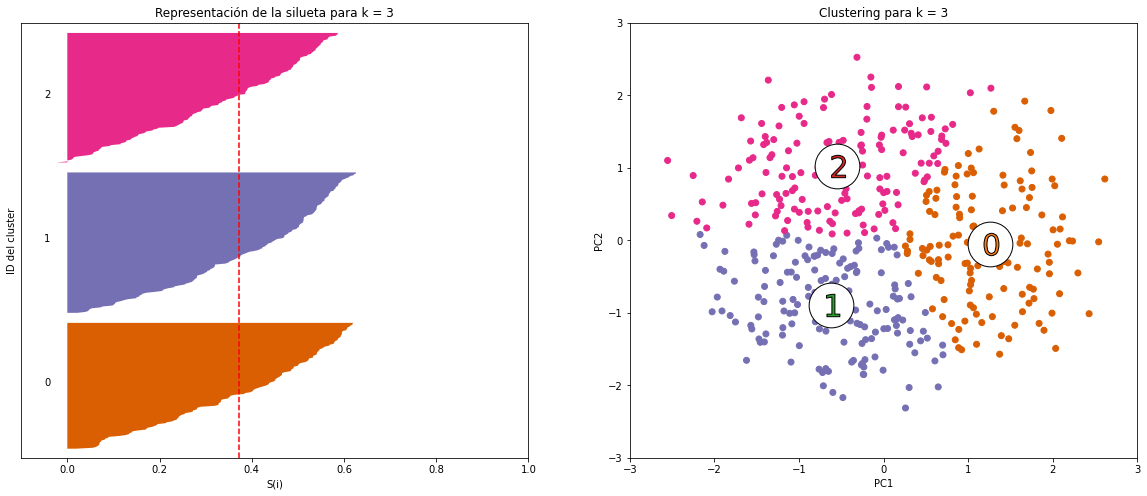

Cluster 0 con 101 objetos
Cluster 1 con 95 objetos
Cluster 2 con 137 objetos
Cluster 3 con 104 objetos
Para k =  4  el promedio de la silueta es: 0.36375653782582756
   - Para i =  0 la silueta del cluster vale:  0.35479604119488856
   - Para i =  1 la silueta del cluster vale:  0.3567185683753483
   - Para i =  2 la silueta del cluster vale:  0.35478513221654523
   - Para i =  3 la silueta del cluster vale:  0.39070557461421235


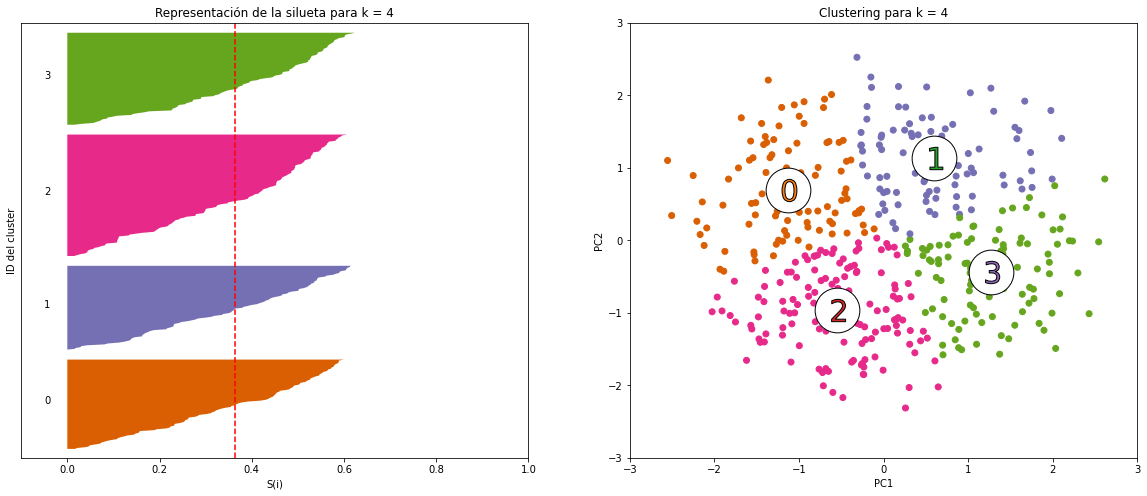

Cluster 0 con 78 objetos
Cluster 1 con 89 objetos
Cluster 2 con 72 objetos
Cluster 3 con 95 objetos
Cluster 4 con 103 objetos
Para k =  5  el promedio de la silueta es: 0.3472818459090443
   - Para i =  0 la silueta del cluster vale:  0.33896428557852676
   - Para i =  1 la silueta del cluster vale:  0.34538284035015626
   - Para i =  2 la silueta del cluster vale:  0.39070959024316576
   - Para i =  3 la silueta del cluster vale:  0.3484130967223521
   - Para i =  4 la silueta del cluster vale:  0.32382082436730053


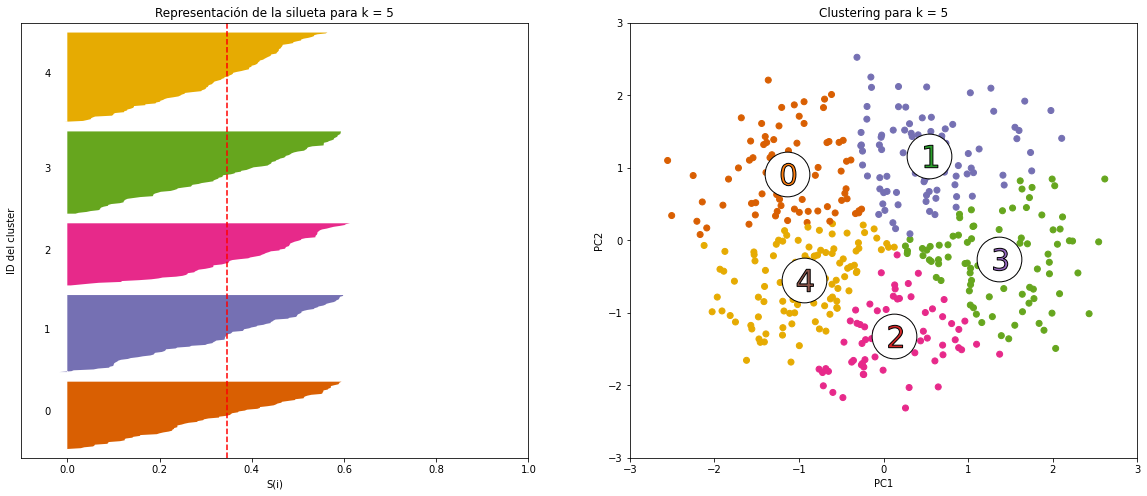

Cluster 0 con 64 objetos
Cluster 1 con 69 objetos
Cluster 2 con 84 objetos
Cluster 3 con 71 objetos
Cluster 4 con 73 objetos
Cluster 5 con 76 objetos
Para k =  6  el promedio de la silueta es: 0.36242749698390986
   - Para i =  0 la silueta del cluster vale:  0.37085136809655705
   - Para i =  1 la silueta del cluster vale:  0.3924606040970903
   - Para i =  2 la silueta del cluster vale:  0.36441495488349046
   - Para i =  3 la silueta del cluster vale:  0.3562108609390927
   - Para i =  4 la silueta del cluster vale:  0.3399266296414765
   - Para i =  5 la silueta del cluster vale:  0.3532904689522784


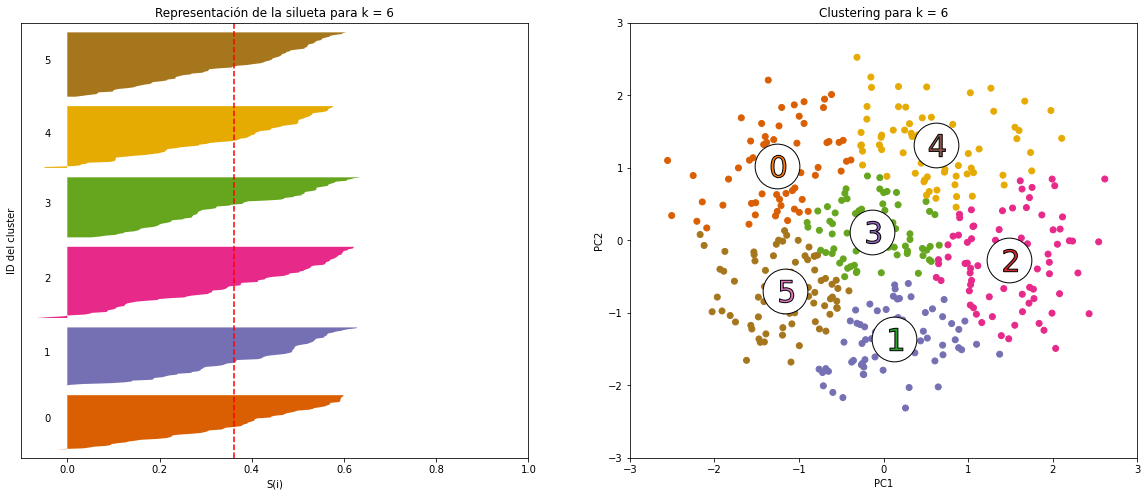

Cluster 0 con 53 objetos
Cluster 1 con 59 objetos
Cluster 2 con 63 objetos
Cluster 3 con 75 objetos
Cluster 4 con 72 objetos
Cluster 5 con 46 objetos
Cluster 6 con 69 objetos
Para k =  7  el promedio de la silueta es: 0.35689807249785743
   - Para i =  0 la silueta del cluster vale:  0.37346349301149456
   - Para i =  1 la silueta del cluster vale:  0.3138262099370181
   - Para i =  2 la silueta del cluster vale:  0.40516444803105656
   - Para i =  3 la silueta del cluster vale:  0.3586426629507321
   - Para i =  4 la silueta del cluster vale:  0.3421484291624032
   - Para i =  5 la silueta del cluster vale:  0.35850860009698027
   - Para i =  6 la silueta del cluster vale:  0.34935512629354776


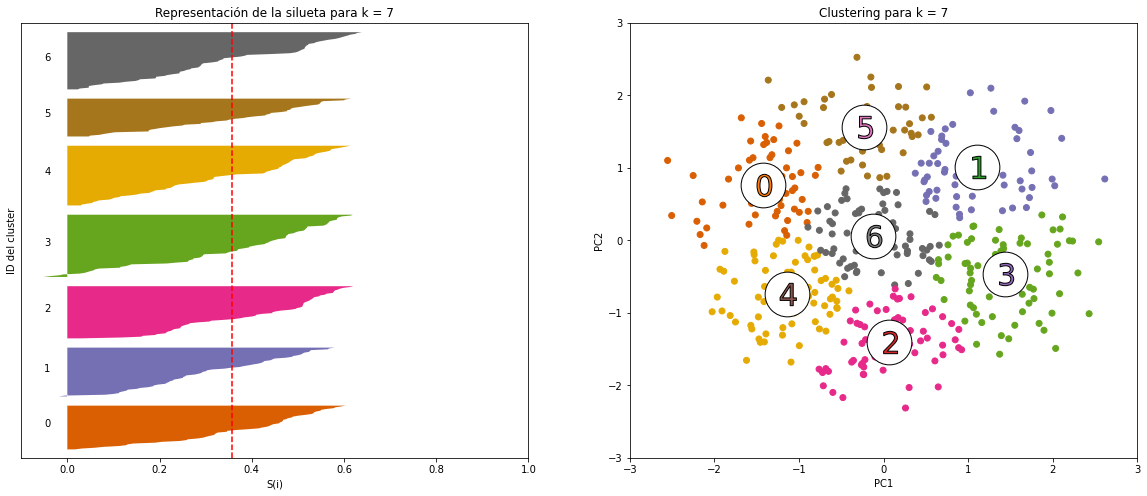

In [34]:
#Se realizará un plot por cada número de clusters graficando: a la izquierda el método de la silueta
#y a la derecha los clusters correspondientes.

for k in K:
    #Se calcula KMeans  para cada iteración
    kmeanModel = KMeans(n_clusters = k, random_state=342543).fit(X)
    #Se guarda en un dataframe  la lista con los centros para luego graficarlos.
    centers = pd.DataFrame(kmeanModel.cluster_centers_)
    #Se guardan los labels para luego seleccionar el color y agregar datos al método de la silueta.
    labels = kmeanModel.labels_
    labels_array.append(labels)
    #Se imprime la cantidad de datos contenidos en cada cluster.
    unique, counts = np.unique(labels, return_counts=True)
    dix =dict(zip(unique, counts))
    if k !=1:
        for i in dix:
            print("Cluster {} con {} objetos".format(i,dix[i]))
    #Se guarda la suma entre el mínimo de las distancias entre cada valor y los clusters y se guarda en el array
    #anteriormente creado para realizar el método del codo.
    ssw_k = sum(np.min(cdist(X, kmeanModel.cluster_centers_, "euclidean"), axis = 1))
    ssw.append(ssw_k)
    
    #Para cada nombre de cluster se selecciona un color de la paleta creada.
    label_color = [color_palette[i] for i in labels]
    
    #Se inicia el código para el gráfico de la silueta, se crea un condicional if para no graficar el primer cluster
    #y para no excederse del máximo posible de clusters que sería el largo del dataframe.
    if 1<k<len(X):
        #Ajustes del plot en un subplot con una fila y dos columnas.
        fig, (axis1,axis2) = plt.subplots(1,2)
        fig.set_size_inches(20,8)
        axis1.set_xlim([-0.1,1.0])
        axis1.set_ylim([0, len(X)+(k+1)*10])
        axis1.set_yticks([])
        
        #Además de los gráficos se añade información numérica calculada por cada número de cluster en cada bucle
        #El primero es el silhouette score, que es el promedio del coeficiente para cada cluster.
        silhoutte_avg = silhouette_score(X, labels)
        print("Para k = ",k," el promedio de la silueta es:", silhoutte_avg)
        #Y el coeficiente de silhouette individual para cada cluster
        sample_silhouette_values = silhouette_samples(X, labels)
        
        #Para la apariencia de las siluetas se deben crear parámetros de distancia, como valor común se usará
        #el valor de 10.
        y_lower = 10
        
        #Sección de pintado de siluetas->
        for i in range(k):
            #Ya habiendo impreso en pantalla el valor del coeficiente de silueta global ahora
            #se imprime el coeficiente de silueta individual de cada cluster utilizando dos funciones conjuntas:
            #np.mean(sample_silhouette_values[labels == i])
            ith_cluster_sv = sample_silhouette_values[labels ==i]
            print("   - Para i = ",i, "la silueta del cluster vale: ", np.mean(ith_cluster_sv))
            #Por seguridad se ordena para luego realizar el plot.
            ith_cluster_sv.sort()
            
            #Se calcula donde colocar la primera silueta en el eje vertical.
            #En cada bucle que recorre la lista de clusters se calcula el tamaño de la silueta siendo separados por
            # 10 unidades guardados en y_upper.
            ith_cluster_size = ith_cluster_sv.shape[0]
            y_upper = y_lower + ith_cluster_size
            
            #Elegimos el color del cluster.
            color = color_palette[i]
            
            #Se pinta la silueta del cluster i-esimo entre el eje "y" y los valores del coef de silueta
            #para cada punto.
            axis1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_sv, facecolor = color, alpha = 1)
            
            #Se etiquetan los cluster con el número en el centro.
            axis1.text(-0.05, y_lower +0.5* ith_cluster_size, str(i))
            
            #Calculamos el nuevo y_lower para el siguiente cluster del gráfico.
            y_lower = y_upper +10
            
        #Se agrega una linea en el gráfico con el promedio del coeficiente de silueta . 
        axis1.axvline(x=silhoutte_avg, color="red", linestyle="--")    
        #Se agrega el título y labels.
        axis1.set_title("Representación de la silueta para k = %s"%str(k))
        axis1.set_xlabel("S(i)")
        axis1.set_ylabel("ID del cluster")
        #Fin del gráfico de la silueta.
    
        #Plot de los k-means
        plt.plot()
        plt.xlim([-3,3])
        plt.ylim([-3,3])
        plt.xlabel("PC{}".format(1), size=10)
        plt.ylabel("PC{}".format(2), size=10)
        axis2.set_title("Clustering para k = %s"%str(k))
        axis2.scatter(transform_data.iloc[:, 0], transform_data.iloc[:, 1], c = label_color)
        axis2.scatter(centers[0], centers[1])
        
        #Plot de los centroides.
        axis2.scatter(centers[0], centers[1], marker='o',c="white", alpha=1, s=2000, edgecolor='k')
        for i in range(len(centers)):
            axis2.scatter(centers[0][i], centers[1][i], marker='$%d$' % (i), alpha=1,
                        s=500, edgecolor='k')

        plt.show()



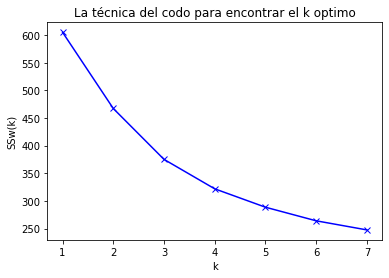

In [35]:
#Ahora se realiza un plot de la técnica del codo
plt.plot(K,ssw, "bx-" )
plt.xlabel("k")
plt.ylabel("SSw(k)")
plt.title("La técnica del codo para encontrar el k optimo")
plt.show()

Analizando la técnica del codo se puede visualizar que el número de cluster óptimmo estaría entre 3 y 4. Esto coincide con el coeficiente de silueta, que para $k = 3$  genera un coef silueta global  $coef= 0.0.3729$ y para $k = 4$  genera un coef silueta global  $coef= 0.3637$. Aunque hay que destacar que los coeficientes no son muy altos debido a la homogeneidad de los datos (generados con un random.choice). La distinción es tal y como se esperó, además con cantidad de compradores muy parecidos, ya que cada cluster contenía clientes aproximadamente la proporción según la cantidad de clusters.

Además se puede segmentar a los clientes con los cluster más a la derecha que son los que más compraron congelados y gourmet y que por lo mismo compraron menos productos lacteos (leche). A la izquierda los que compraron más productos lacteos, pero menos gourmet y congelados. Los cluster de más arriba indican mayor compra de de limpieza y vegetales, mientras que los de abajo una menor cantidad de estos productos.

Obviamente se pueden dar combinaciones de estos, por ejemplo para $k = 3$ (3 clusters) el cluster n°0 está a la derecha, lo que implica mayor compra de congelados y gourmet, que podría ser un restaurante de lujo que necesita para la preparación de distintos platos o una tienda de congelados que tenga productos más gourmet. El cluster n°1 está abajo a la izquierda, indicando que no compra en gran cantidad congelados y gourmet ni cantidades sobre la media de limpieza y vegetales, por lo cual podría ser un negocio de barrio, que aunque compra de todo no lo hace en grandes lotes, además se debe indicar que son negocios que prefieren la venta de lacteos (o productos lacteos como el queso). Finalmente el cluster superior a la izquierda prefiere la compra de limpieza, vegetales y leche (o productos lacteos) que (muy dificil de interpretar) puede ser una verdulería/quesería que se preparó muy bien para la pandemia y compró muchos utencilios de limpieza.

### Parte 10: Recuperación de la data original

In [36]:
#Se invierte el PCA
invtransform = descdata.inverse_transform(ftr)
invtransform

array([[ 0.24448372,  0.69257603,  0.28878762, -0.3361725 , -0.18277079,
        -1.59355212],
       [ 0.83474758,  0.80713346,  0.74707089, -0.12170938, -0.57442608,
         0.02204952],
       [ 0.95232046, -0.71405702,  0.01109311, -0.61702534,  0.94081278,
         0.93492328],
       ...,
       [-0.62651538, -0.16954206,  0.64472562,  0.60475402, -1.31928977,
         1.63731492],
       [-1.21746479, -0.97511578, -0.64699048, -1.66327167,  0.18912208,
        -0.7163191 ],
       [-0.82429833,  0.90259799, -0.94773888, -0.07408953, -0.41596738,
        -1.05456993]])

In [37]:
#Se invierte la estandarización
nostandar = x2.inverse_transform(invtransform)
nostandar

array([[5803., 7054., 5883., 4008., 4588.,  146.],
       [7525., 7366., 7195., 4625., 3498., 4951.],
       [7868., 3223., 5088., 3200., 7715., 7666.],
       ...,
       [3262., 4706., 6902., 6715., 1425., 9755.],
       [1538., 2512., 3204.,  190., 5623., 2755.],
       [2685., 7626., 2343., 4762., 3939., 1749.]])

In [38]:
#Se agregan los cluster al dataframe para K= 3
k3clusters = pd.DataFrame(nostandar, columns = items)
k3clusters["grupo"] = labels_array[2]
k3clusters.head(30)


,congelados,limpieza,vegetales,leche,abarrotes,gourmet,grupo
0,5803.0,7054.0,5883.0,4008.0,4588.0,146.0,1
1,7525.0,7366.0,7195.0,4625.0,3498.0,4951.0,2
2,7868.0,3223.0,5088.0,3200.0,7715.0,7666.0,0
3,8062.0,5820.0,2509.0,5406.0,2761.0,2527.0,1
4,4708.0,366.0,403.0,6136.0,9046.0,3336.0,1
5,1318.0,3359.0,5604.0,5548.0,1535.0,9844.0,0
6,9472.0,7154.0,2671.0,9620.0,6842.0,1457.0,1
7,6395.0,6164.0,7770.0,5172.0,4363.0,7033.0,2
8,1330.0,5574.0,2055.0,3674.0,959.0,3380.0,1
9,5413.0,3103.0,2183.0,6290.0,6466.0,5940.0,1


Como conclusión se pudo segmentar los clientes de la manera:
    - Grupo 0: Tiendas de congelados de productos más refinados y restaurantes de lujo.
    - Grupo 1: Podrían ser negocios de barrio, en localidades donde los productos lacteos son muy solicitados.
    - Grupo 2: Puede ser un grupo espontaneo, ya que podría ser una verdulería y/o quesería que por proyectarse en el tiempo de pandemia se abasteció de productos de limpieza para vender.